In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
%matplotlib notebook

### Probability of going infinite in Magic Arena

<IPython.core.display.Javascript object>


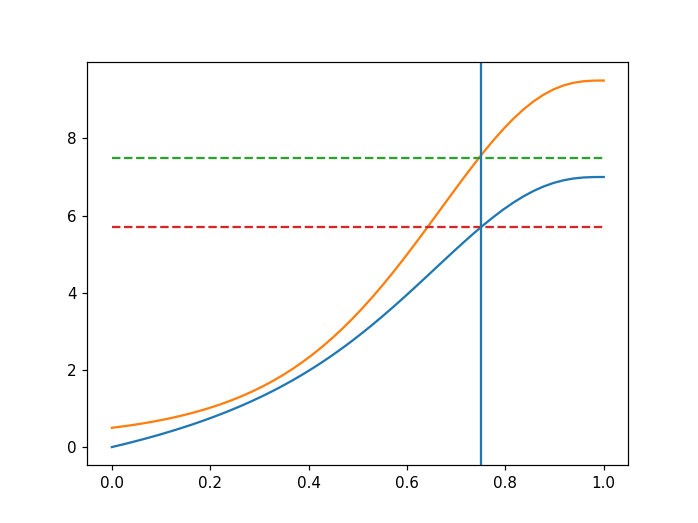

In [4]:
NL = 3
NW = 7
DISCR = 50

wr = np.linspace(0, 1, DISCR)
curves = np.zeros((NW+1, DISCR))
for i in range(NW):
    curves[i] = scipy.special.binom(i+NL-1, NL-1) * wr**i * (1 - wr)**NL

for j in range(NL):
    curves[NW] += scipy.special.binom(NW+j, j) * wr**NW * (1 - wr)**j
    
curves[NW] = scipy.special.binom(NW+1, 2) * wr**NW * (1 - wr)**2
curves[NW] += scipy.special.binom(NW, 1) * wr**NW * (1 - wr)**1
curves[NW] += scipy.special.binom(NW, 0) * wr**NW * (1 - wr)**0

# Self-test 1: Check all probability curves sum up to 1.
# plt.figure()
# plt.plot(wr, np.sum(curves, axis=0))
# plt.show()

# Self-test 2: Plot curves
# plt.figure()
# for i in range(NW+1):
#     plt.plot(wr, curves[i], label=str(i))
    
# plt.show()
# plt.legend()

wcount = list(range(NW+1))
mcount = np.array([0.5, 1.0, 2.0, 3.0, 4.5, 6.5, 8.5, 9.5])
avgWR = np.zeros(DISCR)
avgM = np.zeros(DISCR)
for i in range(DISCR):
    avgWR[i] = np.dot(curves[:, i], wcount)
    avgM[i] = np.dot(curves[:, i], mcount)
    
plt.figure()
plt.plot(wr, avgWR, label="avgWR")
plt.plot(wr, avgM, label="avgM")
plt.plot(wr, np.zeros(DISCR)+7.5, '--', label="$$")
plt.plot(wr, np.zeros(DISCR)+5.7, '--', label="$$")
plt.axvline(x=0.75)
# plt.plot(wr, NW*wr, '--')
plt.legend()
plt.show()

### Probability of going infinite in MTGO friendly constructed

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<IPython.core.display.Javascript object>


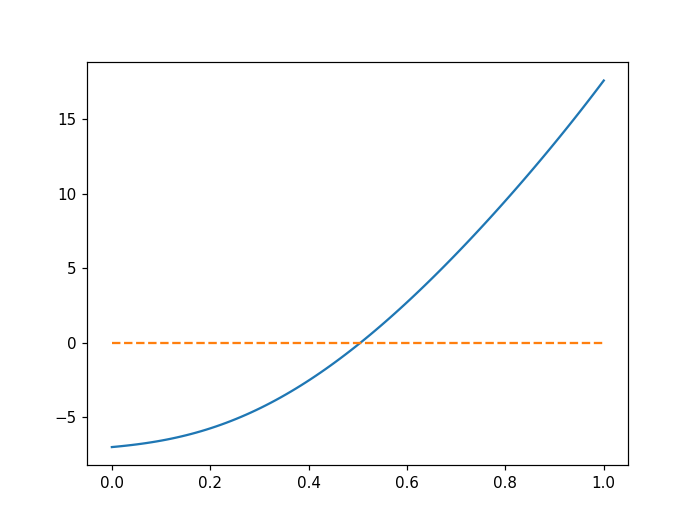

In [5]:
TreasureChestValue = 2.2
winRewards = np.array([1, 2, 4, 8+TreasureChestValue, 8 + 4*TreasureChestValue, 8+8*TreasureChestValue])
def winProbs(pw):
    pl = 1-pw
    return np.array([pl**3, 3 * pw*(pl**3), 6*(pw**2)*(pl**3), 10*(pw**3)*(pl**2), 5*(pw**4)*pl, pw**5])

# Selftest
print(np.sum(winProbs(np.linspace(0, 1, 10)), axis=0))


pw_lst = np.linspace(0, 1, 100)
revenue = np.array([winRewards.dot(winProbs(pw)) for pw in pw_lst]) - 8
plt.figure()
plt.plot(pw_lst, revenue)
plt.plot(pw_lst, np.zeros(100), '--', label="break_even")

<IPython.core.display.Javascript object>


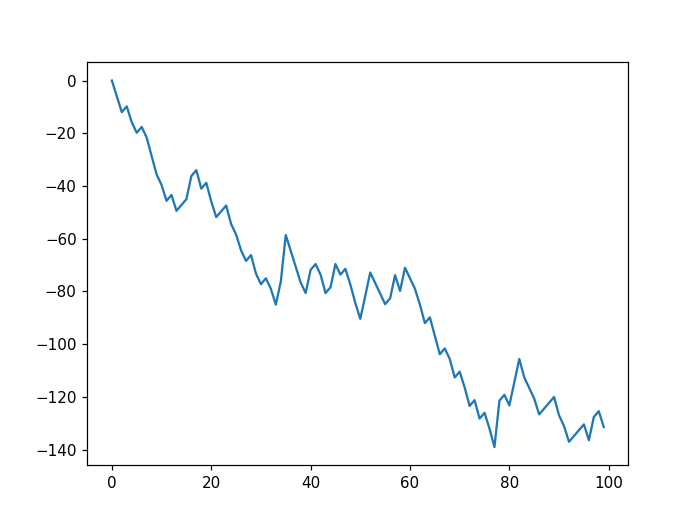

In [6]:
def posCCD(ccd, p):
    i = 1
    while (i < len(ccd)) and (ccd[i] <= p):
        i += 1
    return i-1

def simulateWithoutRebuy(pw, Nstep):
    # Get probability of each state and construct cumulative distribution
    WP_LST = winProbs(pw)
    N_STATE = len(WP_LST)
    WP_CCD = np.zeros(N_STATE+1)
    for i in range(1, N_STATE+1):
        WP_CCD[i] = WP_CCD[i-1] + WP_LST[i-1]
        
    state = np.zeros(Nstep)
    for i in range(1, Nstep):
        randState = posCCD(WP_CCD, np.random.uniform(0, 1))
        state[i] = state[i-1] + winRewards[randState] - 8
        
    return state

plt.figure()
plt.plot(simulateWithoutRebuy(0.5, 100))

Doing probability 0.5
Doing probability 0.51
Doing probability 0.55


<IPython.core.display.Javascript object>


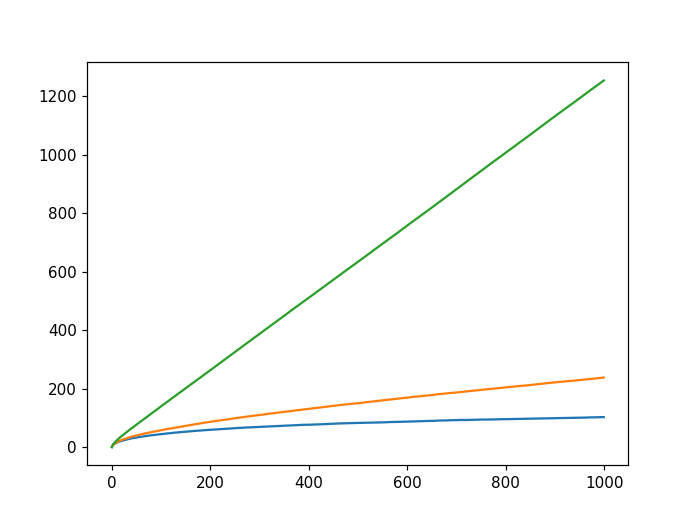

<IPython.core.display.Javascript object>


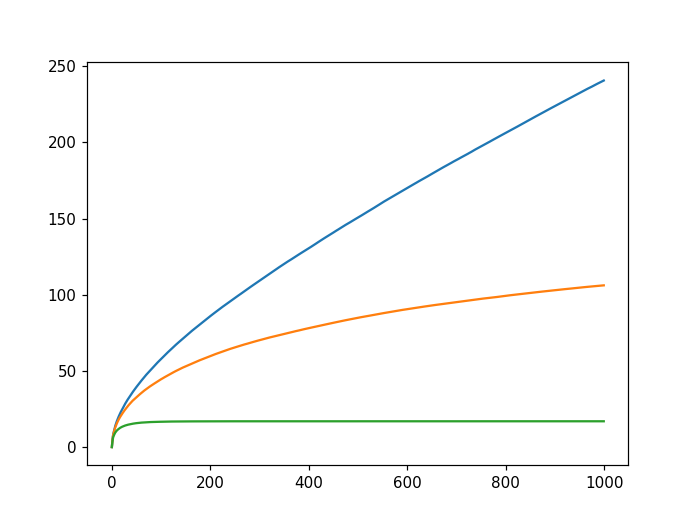

In [15]:
def simulateWithRebuy(pw, Nstep):
    # Get probability of each state and construct cumulative distribution
    WP_LST = winProbs(pw)
    N_STATE = len(WP_LST)
    WP_CCD = np.zeros(N_STATE+1)
    for i in range(1, N_STATE+1):
        WP_CCD[i] = WP_CCD[i-1] + WP_LST[i-1]
        
    cumulRebuy = np.zeros(Nstep)
    state = np.zeros(Nstep)
    for i in range(1, Nstep):
        randState = posCCD(WP_CCD, np.random.uniform(0, 1))
        state[i] = state[i-1] + winRewards[randState] - 8
        if state[i] < 0:
            state[i] += 8
            cumulRebuy[i] = cumulRebuy[i-1] + 8
        else:
            cumulRebuy[i] = cumulRebuy[i-1]
        
    return state, cumulRebuy

# plt.figure()
# plt.plot(simulateWithRebuy(0.5, 100)[0])


PWIN = [0.5, 0.51, 0.55]
N_GAME = 1000
N_SIM = 10000



avgCap = []
avgReb = []
for pw in PWIN:
    print('Doing probability', pw)
    avgCapital = np.zeros(N_GAME)
    avgCumulRebuy = np.zeros(N_GAME)
    for iTrial in range(N_SIM):
        state, rebuy = simulateWithRebuy(pw, N_GAME)
        avgCapital += state / N_SIM
        avgCumulRebuy += rebuy / N_SIM
    
    avgCap.append(avgCapital)
    avgReb.append(avgCumulRebuy)

plt.figure()
for avgCapital in avgCap:
    plt.plot(avgCapital)
    
plt.figure()
for avgCumulRebuy in avgReb:
    plt.plot(avgCumulRebuy)

So if deck has positive winrate, amount of money necessary for rebuys is anywhere between 0 and 150\$, rapidly declining as winrate increases. Still, using a 